In [ ]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report

# Deep Learning Imports
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout

# PhoBERT Imports
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.optim import AdamW
import os 
import tracemalloc
import time
# Cấu hình
SEED = 42
MAX_LEN = 128  # Độ dài câu tối đa cho DL models
SAVE_DIR = 'saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# Map nhãn (sẽ cập nhật khi load data)
TAG2IDX = {}
IDX2TAG = {}

# DATA UTILS & FEATURE ENGINEERING

In [4]:
def load_data(file_path):
    """Load dữ liệu từ file JSON."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy {file_path}")
        return []

def get_tag_mappings(all_sents):
    """Tạo mapping từ điển cho labels."""
    tags = list(set([t[1] for sent in all_sents for t in sent]))
    tag2idx = {t: i for i, t in enumerate(tags)}
    idx2tag = {i: t for t, i in tag2idx.items()}
    return tag2idx, idx2tag

# --- Feature Engineering cho Classical ML (CRF, LR, RF) ---
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0, 'word.lower()': word.lower(),
        'word.isupper()': word.isupper(), 'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(), 'word.has_underscore': '_' in word,
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({'-1:word.lower()': word1.lower(), '-1:word.istitle()': word1.istitle()})
    else: features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({'+1:word.lower()': word1.lower(), '+1:word.istitle()': word1.istitle()})
    else: features['EOS'] = True
    return features

def prepare_classical_data(sents):
    X = [[word2features(s, i) for i in range(len(s))] for s in sents]
    y = [[label for token, label in s] for s in sents]
    return X, y

# --- Feature Engineering cho Bi-LSTM ---
def prepare_dl_data(sents, word2idx, tag2idx, max_len):
    X = [[word2idx.get(w[0], word2idx.get("UNK", 0)) for w in s] for s in sents]
    X = pad_sequences(X, maxlen=max_len, padding="post", value=word2idx.get("PAD", 0))
    
    y = [[tag2idx[w[1]] for w in s] for s in sents]
    y = pad_sequences(y, maxlen=max_len, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=len(tag2idx)) for i in y]
    return np.array(X), np.array(y)

In [22]:
def measure_performance(model_name, train_func, *args, **kwargs):
    """
    Hàm wrapper để đo thời gian và bộ nhớ của một hàm huấn luyện.
    """
    print(f"\n--- ⏱️ Bắt đầu đo lường: {model_name} ---")
    
    # 1. Bắt đầu theo dõi RAM
    tracemalloc.start()
    
    # 2. Bắt đầu bấm giờ
    start_time = time.time()
    
    # 3. Chạy hàm huấn luyện thực tế
    try:
        model, f1_score = train_func(*args, **kwargs)
    except Exception as e:
        print(f" Lỗi khi chạy {model_name}: {e}")
        tracemalloc.stop()
        return None
    
    # 4. Kết thúc bấm giờ
    end_time = time.time()
    
    # 5. Lấy thông số RAM (current, peak)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    execution_time = end_time - start_time
    peak_memory_mb = peak / (1024 * 1024) # Đổi từ Byte sang MB
    
    print(f" Hoàn tất {model_name}:")
    print(f"   - F1-Score: {f1_score:.4f}")
    print(f"   - Thời gian: {execution_time:.2f}s")
    print(f"   - RAM đỉnh (Peak): {peak_memory_mb:.2f} MB")
    
    return {
        'Model': model_name,
        'F1-Score': f1_score,
        'Time (s)': execution_time,
        'Memory (MB)': peak_memory_mb
    }

# TRAINING 

In [ ]:
# --- CẬP NHẬT HÀM TRAIN CRF ---
def train_crf(X_train, y_train, X_test, y_test):
    print("... Đang training CRF ...")
    crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
    crf.fit(X_train, y_train)
    
    y_pred = crf.predict(X_test)
    
    # IN BÁO CÁO NGAY TẠI ĐÂY
    print("\n" + "="*40)
    print(">>> DETAILED REPORT: CRF")
    print("="*40)
    print(flat_classification_report(y_test, y_pred, digits=4))
    
    report = flat_classification_report(y_test, y_pred, digits=4, output_dict=True)
    return crf, report['weighted avg']['f1-score']

# --- CẬP NHẬT HÀM TRAIN LR & RF ---
def train_classical_sklearn(model_name, X_train, y_train, X_test, y_test):
    print(f"... Đang training {model_name} ...")
    
    # Flatten & Vectorize
    X_train_flat = [item for sublist in X_train for item in sublist]
    y_train_flat = [item for sublist in y_train for item in sublist]
    X_test_flat = [item for sublist in X_test for item in sublist]
    y_test_flat = [item for sublist in y_test for item in sublist]
    
    v = DictVectorizer(sparse=False)
    X_train_vec = v.fit_transform(X_train_flat)
    X_test_vec = v.transform(X_test_flat)
    
    if model_name == 'LogisticRegression':
        clf = LogisticRegression(max_iter=500, n_jobs=-1)
    elif model_name == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=SEED)
        
    clf.fit(X_train_vec, y_train_flat)
    y_pred = clf.predict(X_test_vec)
    
    # IN BÁO CÁO NGAY TẠI ĐÂY
    print("\n" + "="*40)
    print(f">>> DETAILED REPORT: {model_name}")
    print("="*40)
    print(classification_report(y_test_flat, y_pred, digits=4))
    
    report = classification_report(y_test_flat, y_pred, digits=4, output_dict=True)
    return clf, report['weighted avg']['f1-score']

# --- CẬP NHẬT HÀM TRAIN BI-LSTM ---
def train_bilstm(train_sents, test_sents, word2idx, tag2idx):
    print("... Đang training Bi-LSTM ...")
    X_train, y_train = prepare_dl_data(train_sents, word2idx, tag2idx, MAX_LEN)
    X_test, y_test = prepare_dl_data(test_sents, word2idx, tag2idx, MAX_LEN)
    
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

    model = Sequential([
        Embedding(input_dim=len(word2idx), output_dim=50, input_length=MAX_LEN),
        Bidirectional(LSTM(units=64, return_sequences=True)),
        Dropout(0.3),
        TimeDistributed(Dense(len(tag2idx), activation="softmax"))
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_tr, y_tr, validation_data=(X_val, y_val), batch_size=32, epochs=30, verbose=0)

    # Evaluate
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=-1)
    y_true = np.argmax(y_test, axis=-1)
    
    flat_pred, flat_true = [], []
    for i in range(len(test_sents)):
        true_len = len(test_sents[i])
        flat_pred.extend([IDX2TAG[idx] for idx in y_pred[i][:true_len]])
        flat_true.extend([IDX2TAG[idx] for idx in y_true[i][:true_len]])
    
    # IN BÁO CÁO NGAY TẠI ĐÂY
    print("\n" + "="*40)
    print(">>> DETAILED REPORT: Bi-LSTM")
    print("="*40)
    print(classification_report(flat_true, flat_pred, digits=4))

    report = classification_report(flat_true, flat_pred, digits=4, output_dict=True)
    return model, report['weighted avg']['f1-score']

In [7]:
class NERDataset(Dataset):
    def __init__(self, sents, tokenizer, tag2idx, max_len=128):
        self.sents = sents
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self): return len(self.sents)

    def __getitem__(self, idx):
        sent = self.sents[idx]
        words = [t[0] for t in sent]
        labels = [self.tag2idx[t[1]] for t in sent]

        # Tokenize & Align labels (Xử lý subword)
        tokenized_inputs = self.tokenizer(words, is_split_into_words=True, 
                                          padding='max_length', truncation=True, max_length=self.max_len, return_tensors="pt")
        word_ids = tokenized_inputs.word_ids(batch_index=0)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100) # Ignore token đặc biệt
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx]) # Lấy label cho subword đầu tiên
            else:
                label_ids.append(-100) # Ignore các subword tiếp theo
            previous_word_idx = word_idx

        return {
            'input_ids': tokenized_inputs['input_ids'][0],
            'attention_mask': tokenized_inputs['attention_mask'][0],
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

def train_phobert(train_sents, test_sents, tag2idx):
    print("... Training PhoBERT (vinai/phobert-base) ...")
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
    model = AutoModelForTokenClassification.from_pretrained("vinai/phobert-base-v2", num_labels=len(tag2idx))
    model.to(device)
    
    train_dataset = NERDataset(train_sents, tokenizer, tag2idx)
    test_dataset = NERDataset(test_sents, tokenizer, tag2idx)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) # Batch nhỏ vì BERT nặng
    
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Training Loop đơn giản (1 epoch demo)
    model.train()
    for epoch in range(1): # Tăng epoch nếu có GPU mạnh
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    # Evaluation Loop
    model.eval()
    true_labels, pred_labels = [], []
    idx2tag = {v: k for k, v in tag2idx.items()}
    
    test_loader = DataLoader(test_dataset, batch_size=8)
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=mask)
            preds = torch.argmax(outputs.logits, dim=2)
            
            for i in range(len(labels)):
                # Lọc bỏ -100 để lấy nhãn thật
                true_ids = labels[i][labels[i] != -100]
                pred_ids = preds[i][labels[i] != -100]
                
                true_labels.extend([idx2tag[t.item()] for t in true_ids])
                pred_labels.extend([idx2tag[p.item()] for p in pred_ids])

    report = classification_report(true_labels, pred_labels, digits=4, output_dict=True)
    return model, report['weighted avg']['f1-score']

# KỊCH BẢN SO SÁNH 

In [8]:
# --- Setup dữ liệu ---
current_folder = os.getcwd()
data_folder_path = os.path.abspath(os.path.join(current_folder, '..', 'Data'))

path_aug = os.path.join(data_folder_path, 'train_bio_augmented.json')
path_org = os.path.join(data_folder_path, 'train_bio.json') # File gốc (không augment)


In [9]:

data_aug = load_data(path_aug)
if not data_aug: exit()
train_sents_aug, test_sents_aug = train_test_split(data_aug, test_size=0.2, random_state=SEED)

# Setup vocab cho Deep Learning
words = list(set([t[0] for sent in data_aug for t in sent])) + ["UNK", "PAD"]
TAG2IDX, IDX2TAG = get_tag_mappings(data_aug)
word2idx = {w: i for i, w in enumerate(words)}

## 1. SO SÁNH CÁC MÔ HÌNH (Trên cùng dữ liệu Augmented)


=== KỊCH BẢN 1: SO SÁNH HIỆU SUẤT CÁC MODEL ===
... Training CRF ...
... Training LogisticRegression ...
... Training RandomForest ...
... Training Bi-LSTM ...


c:\Users\vthuy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


... Training PhoBERT (vinai/phobert-base) ...


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bỏ qua PhoBERT do lỗi: word_ids() is not available when using non-fast tokenizers (e.g. instance of a `XxxTokenizerFast` class).


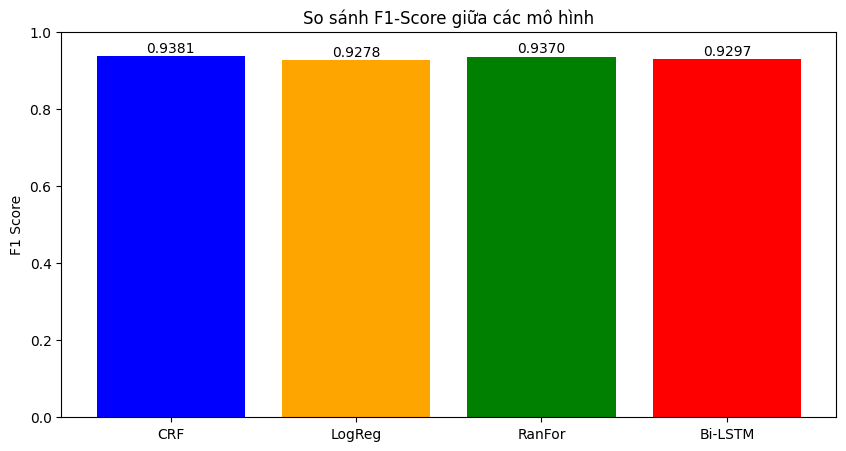

In [21]:
performance_log = []

# --- 1. Chuẩn bị dữ liệu ---
X_train_cls, y_train_cls = prepare_classical_data(train_sents_aug)
X_test_cls, y_test_cls = prepare_classical_data(test_sents_aug)

# --- 2. Chạy từng Model (Sẽ tự in Report chi tiết) ---

# A. CRF
res_crf = measure_performance(
    "CRF", 
    train_crf, 
    X_train_cls, y_train_cls, X_test_cls, y_test_cls
)
if res_crf: performance_log.append(res_crf)

# B. Logistic Regression
res_lr = measure_performance(
    "Logistic Regression", 
    train_classical_sklearn, 
    "LogisticRegression", X_train_cls, y_train_cls, X_test_cls, y_test_cls
)
if res_lr: performance_log.append(res_lr)

# C. Random Forest
res_rf = measure_performance(
    "Random Forest", 
    train_classical_sklearn, 
    "RandomForest", X_train_cls, y_train_cls, X_test_cls, y_test_cls
)
if res_rf: performance_log.append(res_rf)

# D. Bi-LSTM
res_lstm = measure_performance(
    "Bi-LSTM", 
    train_bilstm, 
    train_sents_aug, test_sents_aug, word2idx, TAG2IDX
)
if res_lstm: performance_log.append(res_lstm)


# --- 3. Tổng hợp và Hiển thị Bảng kết quả (Ở cuối cùng) ---
df_results = pd.DataFrame(performance_log)
print("\n\n")
print("="*60)
print(">>> BẢNG TỔNG HỢP SO SÁNH CUỐI CÙNG")
print("="*60)
print(df_results)

# --- 4. Vẽ Biểu đồ So sánh ---
if not df_results.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # F1-Score
    axes[0].bar(df_results['Model'], df_results['F1-Score'], color='teal')
    axes[0].set_title('F1-Score')
    axes[0].set_ylim(0, 1.0)
    for i, v in enumerate(df_results['F1-Score']):
        axes[0].text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

    # Thời gian
    axes[1].bar(df_results['Model'], df_results['Time (s)'], color='salmon')
    axes[1].set_title('Training Time (s)')
    for i, v in enumerate(df_results['Time (s)']):
        axes[1].text(i, v, f"{v:.1f}s", ha='center', va='bottom')

    # Bộ nhớ
    axes[2].bar(df_results['Model'], df_results['Memory (MB)'], color='purple')
    axes[2].set_title('Peak Memory (MB)')
    for i, v in enumerate(df_results['Memory (MB)']):
        axes[2].text(i, v, f"{v:.1f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## 2. SO SÁNH AUGMENTED vs ORIGINAL DATA (Sử dụng CRF làm đại diện)

-> Training CRF on Original Data...
... Training CRF ...
CRF Original F1:  0.8670
CRF Augmented F1: 0.9381


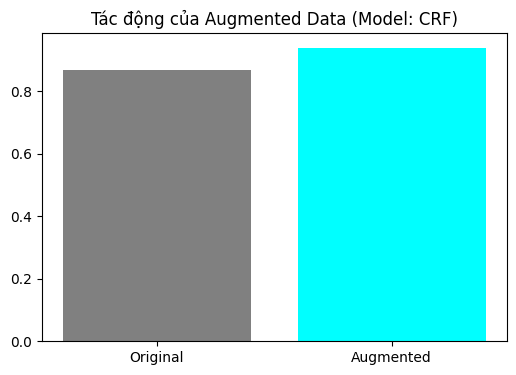

In [15]:
data_org = load_data(path_org) # Load data gốc

if data_org:
    # Train/Test split cho Org
    train_sents_org, test_sents_org = train_test_split(data_org, test_size=0.2, random_state=SEED)
    
    # Chuẩn bị dữ liệu
    X_train_org, y_train_org = prepare_classical_data(train_sents_org)
    X_test_org, y_test_org = prepare_classical_data(test_sents_org)
    
    # Train CRF trên Org
    print("-> Training CRF on Original Data...")
    _, f1_org = train_crf(X_train_org, y_train_org, X_test_org, y_test_org)
    
    print(f"CRF Original F1:  {f1_org:.4f}")
    # Kiểm tra xem f1_crf (từ augmented data) đã tồn tại chưa
    if 'f1_crf' in globals():
        print(f"CRF Augmented F1: {f1_crf:.4f}") 
        
        # Biểu đồ
        plt.figure(figsize=(6, 4))
        plt.bar(['Original', 'Augmented'], [f1_org, f1_crf], color=['gray', 'cyan'])
        plt.title("Tác động của Augmented Data (Model: CRF)")
        plt.show()
    else:
        print("Chưa có kết quả f1_crf (Augmented) để so sánh. Hãy chạy Kịch bản 1 trước.")
else:
    print("Không tìm thấy dữ liệu gốc (train_bio.json) để so sánh.")

## 3. ẢNH HƯỞNG CỦA KÍCH THƯỚC DỮ LIỆU (Learning Curve)

>>> BẮT ĐẦU CHẠY LEARNING CURVE ĐA MÔ HÌNH...

--- Tỷ lệ 20% (356 câu) ---
Completed: CRF=0.888, LR=0.869, RF=0.877

--- Tỷ lệ 40% (712 câu) ---
Completed: CRF=0.913, LR=0.901, RF=0.906

--- Tỷ lệ 60% (1068 câu) ---
Completed: CRF=0.923, LR=0.914, RF=0.922

--- Tỷ lệ 80% (1424 câu) ---
Completed: CRF=0.932, LR=0.922, RF=0.927

--- Tỷ lệ 100% (1780 câu) ---
Completed: CRF=0.939, LR=0.928, RF=0.938


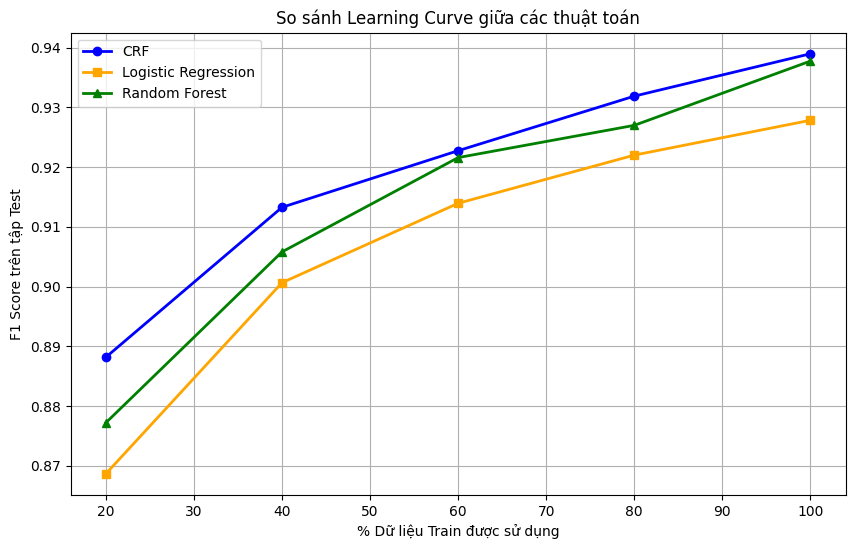

In [19]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer

# --- Cấu hình ---
ratios = [0.2, 0.4, 0.6, 0.8, 1.0]
models_results = {
    'CRF': [],
    'Logistic Regression': [],
    'Random Forest': []
}

# Sử dụng tập Test cố định (Full 100% Test set) để đánh giá công bằng
X_test_cls, y_test_cls = prepare_classical_data(test_sents_aug)

# Chuẩn bị dữ liệu Test cho LR/RF (Flatten 1 lần dùng chung cho việc transform sau này)
# Lưu ý: Vectorizer sẽ fit theo tập train từng vòng, nên tập test chỉ flatten ở đây thôi
X_test_flat = [item for sublist in X_test_cls for item in sublist]
y_test_flat = [item for sublist in y_test_cls for item in sublist]


print(">>> BẮT ĐẦU CHẠY LEARNING CURVE ĐA MÔ HÌNH...")

# Lấy dữ liệu gốc dạng câu (để dễ cắt)
train_source = train_sents_aug 

for r in ratios:
    # 1. Cắt dữ liệu nguồn (theo câu)
    subset_size = int(len(train_source) * r)
    current_sents = train_source[:subset_size]
    
    print(f"\n--- Tỷ lệ {int(r*100)}% ({subset_size} câu) ---")
    
    # 2. Feature Engineering cho tập con này
    X_sub, y_sub = prepare_classical_data(current_sents)
    
    # --- MODEL 1: CRF ---
    try:
        crf_tmp = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=50)
        crf_tmp.fit(X_sub, y_sub)
        y_pred_crf = crf_tmp.predict(X_test_cls)
        score_crf = flat_classification_report(y_test_cls, y_pred_crf, output_dict=True)['weighted avg']['f1-score']
        models_results['CRF'].append(score_crf)
    except:
        models_results['CRF'].append(0)

    # --- CHUẨN BỊ DATA CHO LR & RF (Flatten & Vectorize) ---
    # Phải làm trong vòng lặp vì Vectorizer fit theo lượng từ vựng của tập train hiện tại
    X_sub_flat = [item for sublist in X_sub for item in sublist]
    y_sub_flat = [item for sublist in y_sub for item in sublist]
    
    v_tmp = DictVectorizer(sparse=False)
    X_sub_vec = v_tmp.fit_transform(X_sub_flat)
    X_test_vec_tmp = v_tmp.transform(X_test_flat) # Transform tập test theo vocab hiện tại

    # --- MODEL 2: LOGISTIC REGRESSION ---
    try:
        lr_tmp = LogisticRegression(max_iter=200, n_jobs=-1) # max_iter thấp để chạy nhanh test
        lr_tmp.fit(X_sub_vec, y_sub_flat)
        y_pred_lr = lr_tmp.predict(X_test_vec_tmp)
        score_lr = classification_report(y_test_flat, y_pred_lr, output_dict=True)['weighted avg']['f1-score']
        models_results['Logistic Regression'].append(score_lr)
    except:
        models_results['Logistic Regression'].append(0)

    # --- MODEL 3: RANDOM FOREST ---
    try:
        rf_tmp = RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=42) # n_estimators thấp demo
        rf_tmp.fit(X_sub_vec, y_sub_flat)
        y_pred_rf = rf_tmp.predict(X_test_vec_tmp)
        score_rf = classification_report(y_test_flat, y_pred_rf, output_dict=True)['weighted avg']['f1-score']
        models_results['Random Forest'].append(score_rf)
    except:
        models_results['Random Forest'].append(0)
        
    print(f"Completed: CRF={models_results['CRF'][-1]:.3f}, LR={models_results['Logistic Regression'][-1]:.3f}, RF={models_results['Random Forest'][-1]:.3f}")

# --- 3. VẼ BIỂU ĐỒ SO SÁNH ---
plt.figure(figsize=(10, 6))

colors = {'CRF': 'blue', 'Logistic Regression': 'orange', 'Random Forest': 'green'}
markers = {'CRF': 'o', 'Logistic Regression': 's', 'Random Forest': '^'}

x_axis = [r*100 for r in ratios]

for name, scores in models_results.items():
    plt.plot(x_axis, scores, marker=markers[name], linestyle='-', linewidth=2, label=name, color=colors[name])

plt.title("So sánh Learning Curve giữa các thuật toán")
plt.xlabel("% Dữ liệu Train được sử dụng")
plt.ylabel("F1 Score trên tập Test")
plt.legend()
plt.grid(True)
plt.show()